In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
!pip install openpyxl
from collections import defaultdict
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

# Parameters

In [2]:
save = False
input_clustering = '_new' # '_new' or ''
optimal_cluster = 'st_cluster_final_gid' # 'st_cluster_final_gid' or 'st_cluster_3_5_7'

test_case = 'block'
historic_ref = '' # '_Full' '_Discount' or ''
premium_type = '' # '_Full'  '_Discount' or ''

use_reinsurance = True
base_case = ''
if use_reinsurance == False:
    base_case = '_base_case'

In [3]:
if test_case == 'historic':
    simulations = 1
else:
    steps = 100
    simulations = 1000

# Data Load

## Simulations

In [4]:
# Simulation data
state_balance_df = pd.read_csv(f'Results/state_balance_{test_case}{input_clustering}{premium_type}{base_case}.csv')
final_balances_df = pd.read_csv(f'Results/final_balances_{test_case}{input_clustering}{premium_type}{base_case}.csv')
cluster_state_df = pd.read_csv(f'Results/cluster_state_{test_case}{input_clustering}{premium_type}{base_case}.csv')
balance_transition_df = pd.read_csv(f'Results/balance_transition_{test_case}{input_clustering}{premium_type}{base_case}.csv')

# Historic data
state_balance_df_hist = pd.read_csv(f'Results/state_balance_historic{input_clustering}{historic_ref}.csv')

## Geospatial

In [5]:
# Geospatial data
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)
gdf_states["STATEFP"] = pd.to_numeric(gdf_states["STATEFP"], errors="coerce").astype("Int64")

## NFIP Clustered Claims

In [6]:
if input_clustering == '_new':
    clustered_claims = pd.read_csv("../2_Low_Return_Period/new_clusters_9.24.25.csv")
    optimal_cluster = 'st_cluster_final_gid'
else:
    clustered_claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")

clustered_claims['countyCode']=clustered_claims['countyCode'].apply(lambda x: str(x).zfill(5))
clustered_claims['stateCode']=clustered_claims['countyCode'].str[:2]

/tmp/ipykernel_937/1877075091.py:2: DtypeWarning: Columns (7,51,66) have mixed types. Specify dtype option on import or set low_memory=False.
  clustered_claims = pd.read_csv("../2_Low_Return_Period/new_clusters_9.24.25.csv")


In [7]:
# Create the new field 'percentageDamageAmount'
clustered_claims['percentageBuildingDamageAmount'] = ((clustered_claims['buildingDamageAmount'] / clustered_claims['buildingPropertyValue']) * 100).clip(upper=100)
# Create new field for 'totalClaimPaid'
clustered_claims['totalClaimPaid'] = clustered_claims['amountPaidOnBuildingClaim'].fillna(0) + clustered_claims['amountPaidOnContentsClaim'].fillna(0)
# Filter stateOwnedIndicator is True
clustered_claims = clustered_claims[clustered_claims['stateOwnedIndicator'] != True]

In [8]:
# Load CPI data
CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/US_BLS_CPIAUCSL.csv", parse_dates=["DATE"]) 

# Ensure 'CPIAUCSL' is numeric
CPI_insurance["CPIAUCSL"] = pd.to_numeric(CPI_insurance["CPIAUCSL"], errors="coerce")

# Handle missing or non-numeric values by forward and backward filling
CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
CPI_insurance["CPIAUCSL"].fillna(method="bfill", inplace=True)

# Extract year and calculate annual average CPI
CPI_insurance['Year'] = CPI_insurance["DATE"].dt.year
CPI_insurance = CPI_insurance.groupby('Year')["CPIAUCSL"].mean().reset_index()
CPI_insurance = CPI_insurance.rename(columns={"CPIAUCSL": "CPI"})

# Base CPI for adjustment (e.g., 2024)
BASE_CPI = 313.3

# Filter claims to only include those from 1998 to present
clustered_claims['dateOfLoss'] = pd.to_datetime(clustered_claims['dateOfLoss'])

# Extract month (abbreviated) and year from 'dateOfLoss'
clustered_claims.loc[:, 'yearOfLoss'] = clustered_claims['dateOfLoss'].dt.year

# Merge clustered_claims with CPI_insurance on month (abbreviation) and year
claims_merged = pd.merge(clustered_claims, CPI_insurance, left_on=['yearOfLoss'], right_on=['Year'])

# Create 'adjustedClaim' column by dividing the CPI for May 2024 by the CPI at the time of loss, and multiplying by 'totalClaimPaid'
claims_merged['adjustedClaim'] = (BASE_CPI / claims_merged['CPI']) * claims_merged['totalClaimPaid']

# Drop unnecessary columns and keep relevant ones
adjusted_claims = claims_merged[['dateOfLoss', 'totalClaimPaid', 'adjustedClaim', 'yearOfLoss']]

clustered_claims = claims_merged

/tmp/ipykernel_937/2656989844.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_937/2656989844.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_937/2656989844.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inp

In [9]:
if input_clustering == '':
    # Katrina
    katrina = 4
    katrina_numbers =[4520, 1707, 1561, 1246, 2187, 1481] 
    
    clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
        lambda x: katrina if x in katrina_numbers else x
    )
    
    # Sandy
    sandy = 87
    sandy_numbers =[1603, 1507, 1252] 
    
    clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
        lambda x: sandy if x in sandy_numbers else x
    )
    
    # Harvey
    harvey = 327
    harvey_numbers =[3430, 5719, 5614, 5712, 5678, 5611, 1456, 1736] 
    
    clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
        lambda x: harvey if x in harvey_numbers else x
    )
    
    # Ian
    ian = 166
    ian_numbers =[3907, 4050] 
    
    clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
        lambda x: ian if x in ian_numbers else x
    )
    
    # ike
    ike = 8
    ike_numbers =[222, 1559, 1419] 
    
    clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
        lambda x: ike if x in ike_numbers else x
    )
    
    # la_2016
    la_2016 = 295
    la_2016_numbers =[3731, 2086, 2053, 3617, 3557] 
    
    clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
        lambda x: la_2016 if x in la_2016_numbers else x
    )
    
    # ivan
    ivan = 6
    ivan_numbers =[159, 364, 4003, 4459, 164, 143, 434]
    
    clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
        lambda x: ivan if x in ivan_numbers else x
    )
    
    # helene
    helene = 190
    helene_numbers =[195] 
    
    clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
        lambda x: helene if x in helene_numbers else x
    )
else:
    clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
        lambda x: 1923 if x in [1927] else x
    ) # ike midwest

## NFIP Policies

In [10]:
if premium_type == '_Full':
    risk_policies = pd.read_excel('../Local_Data/NFIP_Data/updatedNFIPdata_2025.xlsx', sheet_name='2024')
    risk_policies['County Code'] = risk_policies['County Code'].astype(int).astype(str)
    risk_policies['County Code'] = risk_policies['County Code'].apply(lambda x: str(x).zfill(5))
    risk_policies['State'] = risk_policies['State Names'].str.strip().str.upper()
    risk_policies['Policies in Force'] = risk_policies['Policy Count']
    
    aggregated_risk_policies = risk_policies.groupby(['County Code', 'State']).agg({
        'Policies in Force': 'sum',
        'Total Coverage': 'sum',
        'Total Written Premium + FPF': 'sum',
        'Total Annual Payment': 'sum'
    }).reset_index()

else:
    risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

    risk_policies['County'] = risk_policies['County'].str.strip()
    risk_policies['State'] = risk_policies['State'].str.strip()
    
    aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
        'Policies in Force': 'sum',
        'Total Coverage': 'sum',
        'Total Written Premium + FPF': 'sum',
        'Total Annual Payment': 'sum'
    }).reset_index()

In [11]:
# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

In [12]:
state_abbrev_dict = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA',
    '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL',
    '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN',
    '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME',
    '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS',
    '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND',
    '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI',
    '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT',
    '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI',
    '56': 'WY'
}

In [13]:
state_claims = pd.read_csv('../Local_Data/NFIP_Data/All_Claims_by_Year.csv')
state_claims = state_claims.groupby("State").aggregate({'Total Claim Dollars Paid':'mean','Total Paid Claims':'mean'}).reset_index()
state_claims['State'] = state_claims['State'].str.upper()
state_claims = state_claims.merge(state_df, left_on='State', right_on='State Name', how='left')
state_policies = aggregated_risk_policies.groupby("State").aggregate({
    'Policies in Force':'sum',
    'Total Coverage':'sum',
    'Total Written Premium + FPF':'sum',
    'Total Annual Payment':'sum'}).reset_index()
state_merged = state_claims.merge(state_policies, left_on='State', right_on='State', how='left')
state_merged['meanLoss'] = state_merged['Total Written Premium + FPF']-state_merged['Total Claim Dollars Paid']

# Merge the aggregated data with the shapefile
gdf_states = gdf_states.merge(state_merged, left_on='GEOID', right_on='State FIPS', how='left')

In [14]:
# Step 1: Compute total premium
total_premium = gdf_states["Total Written Premium + FPF"].sum()

# Step 2: Create a new column for percentage of total
gdf_states["Contribution %"] = 100 * gdf_states["Total Written Premium + FPF"] / total_premium

# Step 3: Create a new column for value of the pool
gdf_states["Benefit"] = 100 / gdf_states["Contribution %"]
gdf_states["OG_Benefit"] = gdf_states["Benefit"]
og_gain_balance = np.min(gdf_states["Benefit"])

# Step 4: Create a new column for the withdrawal max
gdf_states["Withdrawal_threshold"] = gdf_states["Total Written Premium + FPF"]*og_gain_balance
gdf_states["OG_Withdrawal_threshold"] = gdf_states["Withdrawal_threshold"]

# Remove AL and HI for simulation
gdf_states = gdf_states[~gdf_states['State'].isin(['ALASKA', 'HAWAII'])]

# Plotting

## Relative Hyperclusters

In [15]:
# Step 1: Filter to years after 1987 (10 years)
post_initial_period = balance_transition_df[balance_transition_df["year"] > 1987]

# Step 2: Count how many simulations each cluster appears in
cluster_sim_counts = (
    post_initial_period
    .groupby("top_cluster")["simulation"]
    .nunique()
)

# Step 3: Filter to only clusters that appear in at least 20 simulations
if test_case == "historic":
    frequent_clusters = cluster_sim_counts[cluster_sim_counts >= 1].index
else:
    num_thres = simulations*0.2
    frequent_clusters = cluster_sim_counts[cluster_sim_counts >= num_thres].index

# Step 4: Convert to set
events = set(frequent_clusters)
events = (events - {1927}) | {1923}

print(f'{len(events)} Imbalancing events:{events}')
[941, 1171, 1734, 1895, 1923, 2112, 2214, 2578]

19 Imbalancing events:{2112.0, 1923.0, 1734.0, 1355.0, 1676.0, 1101.0, 462.0, 2578.0, 1171.0, 2138.0, 546.0, 2214.0, 1895.0, 2410.0, 1835.0, 941.0, 2486.0, 2040.0, 2687.0}


[941, 1171, 1734, 1895, 1923, 2112, 2214, 2578]

In [16]:
# Define cluster mapping
if input_clustering == '_new':
    cluster_event_map = {
        1734: "KATRINA 2005",
        2214: "SANDY 2012",
        2578: "HARVEY 2017",
        3042: "MILTON/HELENE 2024",
        2939: "IAN 2022",
        1923: "GUSTAV/IKE 2008",
        2506: "2016 LOUISIANA FLOODS",
        1676: "FRANCES/IVAN/JEANNE 2004",
        2138: "IRENE/LEE 2011",
        1455: "ALLISON 2001",
        2590: "IRMA",
        1060: "1995 MISSISSIPPI RIVER FLOODS",
        1355: "FLOYD/IRENE 1999",
        2653: "FLORENCE",
        747: "HUGO",
        2475: "2016 NORTH AMERICAN STORM COMPLEX",
        1074: "OPAL",
        2519: "MATTHEW",
        1289: "GEORGE/MITCH",
        1614: "ISABEL",
        2865: "FRED/IDA/NICHOLAS",
        2731: "BARRY",
        923: "DEC 1992 NOR'EASTER",
        2202: "ISAAC",
        2871: "IDA",
        2410: "2015 TX/OK FLOOD TORNADO OUTBREAK",
        107: "CLAUDETTE",
        941: "1993 GREAT FLOOD",
        1742: "WILMA",
        61: "1979 EASTER FLOOD + STORM?",
        1033: "ROSA",
        1895: "2008 MIDWEST FLOODS",
        1144: "FRAN",
        1545: "HANNA/ISIDORE/LILI",
        119: "DAVID/FREDERIC",
        940: "1993 SUPERSTORM",
        2980: "IDALIA",
        1773: "2006 MID-ATLANTIC US FLOOD",
        1101: "1996 NORTH AMERICAN BLIZZARD",
        2040: "2010 TENNESSEE FLOODS",
        2471: "2016 LOUISIANA HEAVY RAINS",
        2112: "2011 MISSISSIPPI RIVER FLOODS",
        144: "1980 LOUISIANA HEAVY RAINS",
        1828: "APRIL 2007 NOR'EASTER",
        412: "ALICIA",
        2808: "SALLY",
        858: "1991 PERFECT STORM",
        393: "1983 LOWER MISSISSIPPI FLOODS",
        1171: "1997 RED RIVER FLOOD",
        1168: "1997 SPRING FLOOD",
        909: "ANDREW",
        1150: "JOSEPHINE",
        2687: "2019 ARKANSAS RIVER FLOODS",
        2666: "MICHAEL",
        2834: "MAY 2021 SOUTH CENTRAL FLOODS",
        2034: "MAR 2010 NOR'EASTER",
        1417: "GORDON/LESLIE",
        544: "JUAN",
        1956: "2009 SEVERE STORMS",
        2956: "2023 FT LAUDERDALE FLOODS",
        534: "ELENA",
        2324: "2014 FLASH FLOOD",
        1716: "DENNIS",
        2444: "2015 NORTH AMERICAN STORM COMPLEX",
        15: "1978 NEW ORLEANS FLASH FLOOD",
        822: "1991 LA/MS FLOODS",
        2003: "2009 CATASTROPHIC ATLANTA FLOOD",
        1232: "WINTER 1998 BLIZZARD",
        1727: "KATRINA - FL",
        1927: "IKE - MIDWEST",
        718: "1989 TX/LA FLASH FLOODS",
        387: "1982/83 MISSISSIPPI RIVER FLOODS 2",
        2238: "2013 MIDWESTERN FLOODS",
        1706: "2005 DELAWARE RIVER FLOODS",
        0: "1978 BLIZZARD",
        2013: "NOR'IDA",
        449: "1984 NORTHEAST FLOODS",
        364: "1982/83 MISSISSIPPI RIVER FLOODS 1",
        546: "1985 ELECTION DAY FLOODS / JUAN",
        1046: "1995 ATM RIVER 1",
        1748: "2005/06 ATM RIVER",
        1741: "2005 NE FLOODS / TAMMY",
        726: "ALLISON 1989",
        1885: "2008 MISSISSIPPI RIVER FLOODS",
        1161: "1996/97 ATM RIVER 1",
        451: "1984 KY, WV, TN FLOODS",
        1105: "1996 ATM RIVER",
        755: "1989 NEW ORLEANS FLOOD",
        2547: "2017 FLOOD/TORNADO OUTBREAKS",
        2815: "ETA",
        1525: "2002 TX FLOODS",
        604: "1986 MIDWEST FLOODS",
        2460: "2015 MISSISSIPPI RIVER FLOODS",
        851: "BOB",
        2813: "LAURA",
        871: "1992 TX FLOODS",
        2513: "HERMINE",
        1238: "1998 ATM RIVER",
        1835: "2007 TX/OK FLOODS + TORNADOS",
        3040: "DEBBY",
        372: "1983 ATM RIVER",
        559: "1986 ATM RIVER",
        1055: "1995 ATM RIVER 2",
        138: "1980 ATM RIVER",
        276: "1981/82 ATM RIVER",
        2944: "2022/23 ATM RIVER",
        2681: "2019 ATM RIVER",
        926: "1992/93 ATM RIVER 1",
        2536: "2017 ATM RIVER 2",
        1693: "2004/05 ATM RIVER",
        2530: "2016/17 ATM RIVER 1",
        1229: "1997 ATM RIVER 2",
        4: "1978 ATM RIVER 2",
        868: "1992 ATM RIVER 2",
        3002: "2024 ATM RIVER",
        2951: "2023 ATM RIVER 2",
        2103: "2010 ATM RIVER",
        669: "1988 ATM RIVER",
        1558: "2002 ATM RIVER",
        2: "1978 ATM RIVER 1",
        2486: "2016 WEST VIRGINIA DOWNPOUR",
        462: "1984 TULSA MEMORIAL DAY FLOOD",
    }
else:
    cluster_event_map = {
        511: "1978 Summer Flash Floods",
        17: "Hurricane Frederic", # 1979
        231: "1979 Midwest Floods",
        27: "1979 Easter Flood",
        393: "1979 Grand Forks Floods",
        60: "1982 Meramec Flood",
        278: "1984 May Floods",
        5115: "1984 Tulsa Memorial Day Flood",
        65: "1986 Oklahoma Floods",
        367: "1985 Election Day Floods",
        203: "Great Flood of 1993",
        218: "1994 Meramec Flood",
        342: "1995 NOLA Floods",
        157: "Hurricane Fran", # 1996
        137: "1996 Northeast Floods",
        236: "1997 Red River Flood",
        56: "1997 Ohio River Valley Flood",
        268: "1998 Townsville Floods",
        7: "Hurricane Georges", # 1998
        312: "Tropical Storm Allison", # 2001
        147: "Hurricane Isabel", # 2003
        6: "Hurricane Ivan", # 2004
        4: "Hurricane Katrina", # 2005
        153: "2006 Northeast Floods",
        8: "Hurricane Ike", # 2008
        267: "2007 TX/OK Floods",
        199: "2008 Midwest Floods",
        391: "2009 Red River Flood",
        2279: "2010 Central Iowa Floods",
        33: "2010 TN Floods",
        35: "2011 Mississippi River Floods",
        4826: "2011 Souris River Flood",
        5602: "2011 Missouri River Flood",
        91: "Hurricane Irene", # 2011
        131: "Tropical Storm Lee", # 2011
        87: "Hurricane Sandy", # 2012
        54: "2015 Ozarks Flood",
        64: "2015 TX/OK Flood and Tornadoes",
        295: "2016 Louisiana Floods",
        168: "Hurricane Matthew",
        500: "2016 West Virginia Downpour",
        49: "2017 Midwest Floods",
        327: "Hurricane Harvey", # 2017
        376: "Hurricane Florence", # 2018
        63: "2019 Arkansas River Floods",
        5587: "2019 SD Flash Floods",
        263: "2019 Midwest Floods",
        1: "Hurricane Sally", # 2020
        166: "Hurricane Ian", # 2022
        3723: "2022 St. Louis Flash Flood",
        95: "2023 Northeast Floods",
        190: "Hurricane Helene", # 2024
    }

In [17]:
critical_events = [941, 1171, 1734, 1895, 1923, 2112, 2214, 2578]

covered_events = [1734, 2214, 2578]

critical_states = {
    1923: ['48', '17', '29'],
    1676: ['01', '42', '54', '39'],
    2578: ['48'],
    1171: ['46', '27','38'],
    546: ['54', '51'],
    2214: ['44', '36', '34', '9'],
    1835: ['40','20'],
    941: ['29','31','17','19','20'], 
    2486: ['54'],
    2112: ['46','5','29','30','38'],
    1734: ['28', '22', '01'],
    1355: ['11','37','42'],
    1101: ['11','42','54'],
    462: ['40'],
    2138: ['50','42','37','36','34','09'],
    1895: ['18','19','55'],
    2410: ['40'],
    2040: ['47', '21'],
    2687: ['5', '29', '40'],
}

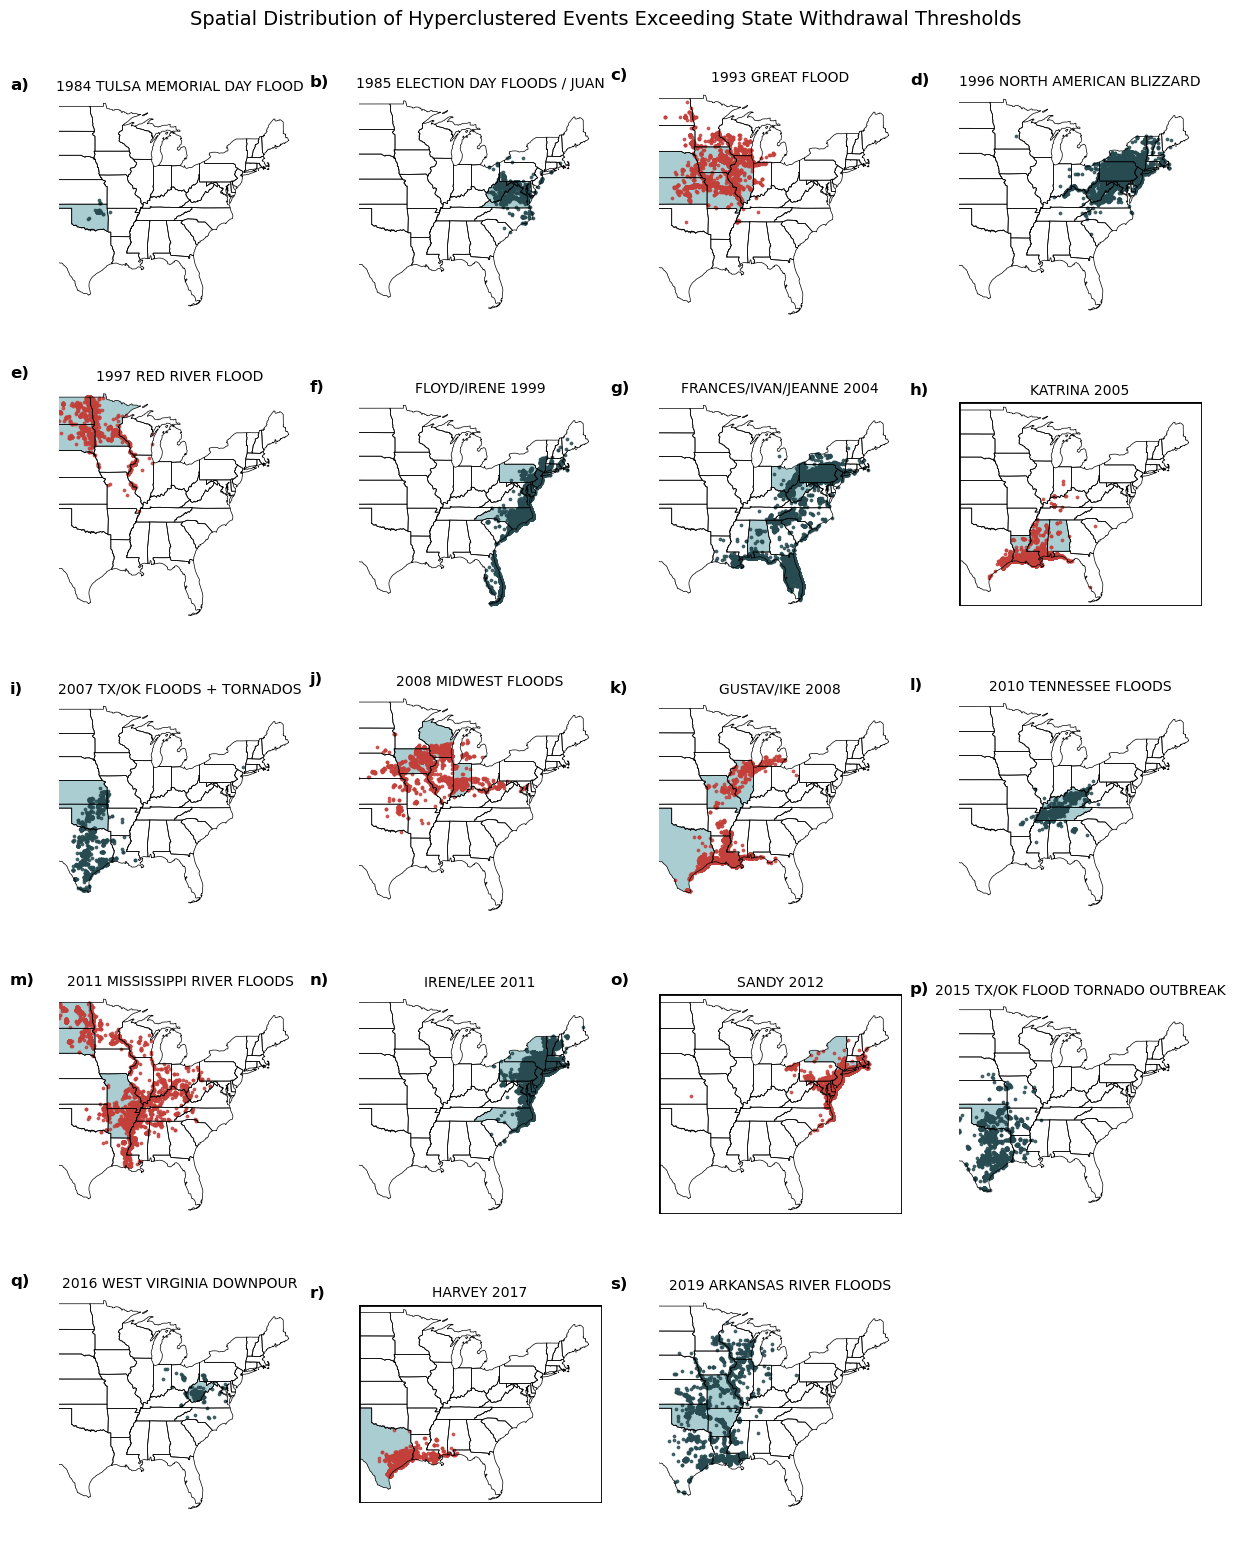

In [18]:
# --- New: normalize critical_states FIPS to 2-digit strings ---
def _norm_fips_list(lst):
    # Handles strings like '9', '05', ints, etc.
    return [str(int(x)).zfill(2) for x in lst]

normalized_critical_states = {
    k: _norm_fips_list(v) for k, v in critical_states.items()
}

# --- Styling choices (tweak as you like) ---
POINT_COLOR_DEFAULT = '#274B51'
POINT_COLOR_CRITICAL = '#C4403A'   # purple
COVERED_FACE = '#F9DCE0'         # light red background for covered events
STATE_FILL = '#40909A'             # light blue state shading
STATE_FILL_ALPHA = 0.45

# Convert events to sorted list for consistent ordering
event_list = sorted(events)

# Set spatial extent for consistency
extent = [-102, -65, 24, 50]

# Adjust grid if more events are needed
n_panels = len(event_list)
ncols = 4
nrows = int(np.ceil(n_panels / ncols))

label_offset = (-0.2, 1.1)

# Prepare figure
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3 * nrows), constrained_layout=True)
axs = axs.flatten()
panel_labels = [f"{chr(97 + i)})" for i in range(len(axs))]

for i, cluster_id in enumerate(event_list):
    ax = axs[i]

    # --- New: background shading for covered events ---
    if cluster_id in covered_events:
        rect = Rectangle(
            (extent[0], extent[2]),        # bottom-left corner (lon_min, lat_min)
            extent[1] - extent[0],         # width
            extent[3] - extent[2],         # height
            fill=False,                    # no fill, just outline
            edgecolor='black',
            linewidth=2.0,                 # thicker line for visibility
            zorder=5,                      # keep on top of base map
        )
        ax.add_patch(rect)

    # Determine name or fallback label
    event_name = cluster_event_map.get(cluster_id, f"Cluster {cluster_id}")

    # Filter points for this cluster
    cluster_points = clustered_claims[clustered_claims[optimal_cluster] == cluster_id]

    # GeoDataFrame for plotting
    gdf_claims_all = gpd.GeoDataFrame(
        cluster_points,
        geometry=gpd.points_from_xy(cluster_points['longitude'], cluster_points['latitude']),
        crs="EPSG:4326"
    )

    # --- New: shade critical states for this cluster (by GEOID) ---
    fips_list = normalized_critical_states.get(cluster_id, [])
    if fips_list:
        # Ensure state GEOIDs are strings and 2-digit padded
        # If your gdf_states already has proper string GEOIDs, this is unnecessary
        states_to_fill = gdf_states[gdf_states['GEOID'].astype(str).str.zfill(2).isin(fips_list)]
        if not states_to_fill.empty:
            states_to_fill.plot(ax=ax, facecolor=STATE_FILL, edgecolor='none', alpha=STATE_FILL_ALPHA)

    # Plot boundaries and points (boundaries on top of fills, points on very top)
    gdf_states.boundary.plot(ax=ax, color='black', linewidth=0.5)

    # --- New: purple points if this is a critical event ---
    point_color = POINT_COLOR_CRITICAL if cluster_id in critical_events else POINT_COLOR_DEFAULT
    gdf_claims_all.plot(ax=ax, color=point_color, markersize=3, alpha=0.8)

    # Format plot
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_title(event_name, fontsize=10)
    ax.axis("off")

    # Panel label
    ax.text(label_offset[0], label_offset[1], panel_labels[i], transform=ax.transAxes,
            ha='left', va='top', fontsize=12, fontweight='bold')

# Turn off any extra axes
for j in range(len(event_list), len(axs)):
    axs[j].axis("off")

plt.suptitle("Spatial Distribution of Hyperclustered Events Exceeding State Withdrawal Thresholds",
             fontsize=14, y=1.03)
if save:
    plt.savefig(f"Plots/New/Clusters_Space_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()